In [13]:
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


def visualize_images_without_points(n_images: int, dataset, shape):
    """Visualize n_images images from the dataset."""
    images = dataset.sample(n_images)
    images = images.apply(lambda x: x.values.reshape(shape), axis=1).values

    fig, axes = plt.subplots(1, n_images, figsize=(n_images, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    plt.show()


def visualize_images_with_points(n_images: int, dataset, shape, points):
    """Visualize n_images images from the dataset."""
    images = dataset.sample(n_images)
    points = points.loc[images.index]
    images = images.apply(lambda x: x.values.reshape(shape), axis=1).values

    fig, axes = plt.subplots(1, n_images, figsize=(n_images, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.plot(points.values[i][0::2], points.values[i][1::2], 'ro', markersize=2)

        ax.axis('off')

    plt.show()


def split_images_points(df):
    images = df['Image'].apply(lambda x: pd.Series(x.split(' ')))
    images = images.astype(np.float32)

    points = df.iloc[:, :-1]

    return images, points


def split_images_pixels(df):
    images = df[' pixels'].apply(lambda x: pd.Series(x.split(' ')))
    images = images.astype(np.float32)

    return images


In [14]:
facial_face_image_shape = (48, 48)
facial_face_points_shape = (96, 96)

original_facial_face_points = pd.read_csv('datasets/data.csv')
original_facial_face_images = pd.read_csv('datasets/icml_face_data.csv')

facial_emotions_targets = original_facial_face_images['emotion']
facial_emotions_images = split_images_pixels(original_facial_face_images)
original_facial_face_images[' pixels'] = facial_emotions_images.values.tolist()

facial_emotions_points_images, points = split_images_points(original_facial_face_points)
original_facial_face_points['Image'] = facial_emotions_points_images.values.tolist()

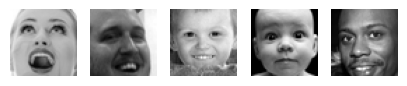

In [15]:
visualize_images_without_points(5, dataset=facial_emotions_images, shape=facial_face_image_shape)

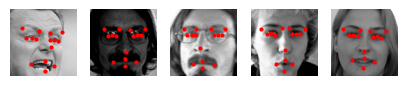

In [16]:
visualize_images_with_points(5, dataset=facial_emotions_points_images, shape=facial_face_points_shape, points=points)

In [17]:
from keras_preprocessing.image import ImageDataGenerator


def rotar_puntos(points, angle):
    # Cambia los puntos en el plano de manera que la rotación está justo en el origen
    # nuestra imagen es de 96*96 ,así que restamos 48
    points = points - 48

    # matriz de rotación
    # R = [ [cos(t), -sin(t)],[sin(t),cos(t)]
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    # rotar los puntos
    for i in range(0, len(points), 2):
        xy = np.array([points[i], points[i + 1]])
        xy_rot = R @ xy
        points[i], points[i + 1] = xy_rot

    # volver al origen del centro de rotación
    points = points + 48
    return points


def get_data_augmentation_flip(df):
    df_flip = df.copy()
    columns = df.columns[:-1]

    images = pd.Series(df_flip['Image'])
    # Horizontal Flip - Damos la vuelta a las imágenes entorno al eje y
    images = images.apply(lambda x: pd.Series(np.flip(x)))

    # dado que estamos volteando horizontalmente, los valores de la coordenada y serían los mismos
    # Solo cambiarían los valores de la coordenada x, todo lo que tenemos que hacer es restar nuestros valores iniciales de la coordenada x del ancho de la imagen (96)
    for i in range(len(columns)):
        if i % 2 == 0:
            df[columns[i]] = df[columns[i]].apply(lambda x: 96. - float(x))

    df_flip['Image'] = pd.Series(images.values.tolist())

    df_flip[columns] = rotar_puntos(df_flip.iloc[:, :-1].values, 180)

    return df_flip


facial_face_points_flipped = get_data_augmentation_flip(original_facial_face_points)
facial_face_points_flipped

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,29.966436,56.997726,65.772992,59.578322,36.417925,56.352577,22.869654,56.030003,59.643429,58.610598,...,38.933197,34.804692,16.029835,67.385504,18.611008,52.687398,23.064541,52.869293,11.514226,"[90.0, 75.0, 70.0, 62.0, 49.0, 39.0, 34.0, 30...."
1,31.667064,61.029923,66.050723,62.551285,37.143830,60.725651,25.277277,59.812834,59.965277,61.638468,...,40.339064,39.578553,19.648000,60.877617,19.952340,49.315404,25.733447,50.532085,10.519830,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,30.942947,61.090358,65.096211,61.090358,36.588000,59.679032,25.015579,59.679032,58.321895,59.679032,...,42.461053,35.177053,22.985684,62.273684,23.268000,48.725053,25.808211,48.725053,17.340632,"[77.0, 78.0, 78.0, 71.0, 69.0, 70.0, 61.0, 56...."
3,30.774261,58.738226,63.976904,58.738226,35.996661,56.872821,23.685287,57.619033,58.381357,57.245885,...,41.833461,30.401113,23.296278,58.754504,21.804522,45.696835,25.908313,44.438817,17.731617,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,29.274699,56.378739,63.755190,57.957968,37.434110,56.378739,23.484074,56.115534,59.017620,56.905148,...,31.110479,35.328589,18.476761,64.808245,19.002699,51.037252,22.292613,51.772859,9.128834,"[176.0, 170.0, 140.0, 83.0, 46.0, 43.0, 37.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,28.819622,60.183627,62.760044,61.078068,36.652027,58.999096,23.332104,58.902400,56.595651,59.410056,...,35.934604,31.602390,22.751607,60.553569,21.985252,47.291374,19.239148,47.440388,18.664382,"[153.0, 161.0, 165.0, 167.0, 170.0, 173.0, 173..."
2136,30.275510,59.698980,70.622449,58.688776,37.469388,58.260204,21.551020,58.474490,62.448980,57.892857,...,33.527211,29.071879,16.770954,67.984623,14.848278,47.228024,14.183226,46.712729,13.128844,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14...."
2137,27.569134,57.348025,67.104143,58.382973,34.340650,55.899098,20.413208,55.780818,58.334882,56.912755,...,32.710424,27.135603,18.504177,73.986019,18.631005,46.819372,16.956870,48.823261,6.455478,"[75.0, 51.0, 39.0, 36.0, 38.0, 38.0, 39.0, 39...."
2138,31.847820,65.308408,68.999102,55.131918,39.494376,61.873037,22.563224,67.443665,61.253878,55.493061,...,36.264201,22.269257,25.726114,57.222857,15.315714,37.957143,16.698571,37.388914,15.644457,"[57.0, 177.0, 179.0, 185.0, 187.0, 189.0, 191...."


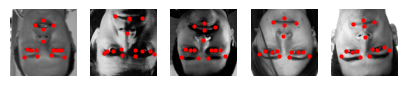

In [18]:
points = facial_face_points_flipped.iloc[:, :-1]
images = facial_face_points_flipped['Image'].apply(lambda x: pd.Series(x))

visualize_images_with_points(5, dataset=images, shape=facial_face_points_shape, points=points)

In [19]:
from scipy import ndimage, misc


def get_data_augmentation_rotate(df, angles):
    def rotate_images(element, rotation_angles: list):
        rotation_angle = np.random.choice(rotation_angles, 1)[0]

        image = element['Image']
        rotated_image = np.array(image).reshape(facial_face_points_shape)
        rotated_image = ndimage.rotate(rotated_image, rotation_angle, reshape=False)

        rotated_points = rotar_puntos(element[:-1].values, rotation_angle)
        element.loc[element[:-1].index.values] = rotated_points
        element['Image'] = np.array(rotated_image).reshape(-1)

        return element

    df_rotations = pd.DataFrame()

    new_df_rotations = df.apply(rotate_images, rotation_angles=angles, axis=1)
    df_rotations = pd.concat([df_rotations, new_df_rotations])

    print(f'Rotated {len(df_rotations)} images')

    return df_rotations


angles_to_rotate = [-120, -80, -50, -10, 10, 15, 25, 50, 80, 90, 120, 150, 165]
facial_face_points_rotated = [
    get_data_augmentation_rotate(original_facial_face_points, angles_to_rotate),
    get_data_augmentation_rotate(original_facial_face_points, angles_to_rotate),
    get_data_augmentation_rotate(original_facial_face_points, angles_to_rotate),
    get_data_augmentation_rotate(original_facial_face_points, angles_to_rotate),
    get_data_augmentation_rotate(original_facial_face_points, angles_to_rotate),
]
facial_face_points_rotated[0]

Rotated 2140 images
Rotated 2140 images
Rotated 2140 images
Rotated 2140 images
Rotated 2140 images


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,53.729535,28.677968,62.488669,63.492426,54.214477,35.143473,51.544170,21.857045,60.471260,57.624028,...,53.099483,14.224192,40.556719,22.423750,72.194339,24.257325,56.946183,12.914070,59.131006,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 202.6..."
1,35.595987,31.186786,69.201810,38.616409,40.807386,32.898181,29.108921,30.708605,63.087465,37.923093,...,55.346502,32.527469,73.206298,53.179554,78.424931,43.507575,69.848290,40.745225,84.858416,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,33.475199,32.146588,67.109597,38.077240,38.789416,34.516726,27.392806,32.507196,60.193125,38.290777,...,53.531679,31.028172,70.407611,57.762168,74.834865,44.860474,69.980550,43.390094,78.319488,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,36.926349,30.987950,67.018163,45.019994,40.871096,34.885663,30.028565,29.006354,61.316184,44.007733,...,51.946877,21.609748,62.951564,46.676204,76.286216,36.576273,67.048508,31.980501,73.927450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,32.081326,35.060296,65.795657,42.459085,39.962712,37.172106,26.419888,33.815808,60.947025,42.249857,...,65.530595,28.119180,73.237657,56.730465,80.359536,44.280198,73.617527,41.583704,86.523151,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,32.670832,64.773320,37.683672,31.193212,35.197450,57.265599,32.979697,70.399954,38.255908,37.553601,...,47.933865,70.017398,68.532831,75.799430,40.154562,76.200859,53.692130,76.792769,53.645187,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2136,69.199348,49.269369,33.752772,68.567976,62.249880,51.620291,76.142733,43.846684,40.433245,63.791955,...,32.641480,48.777710,11.490793,14.116948,29.282078,31.760163,18.327827,31.679231,17.157057,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2137,30.684746,33.682604,69.140496,42.915334,36.850518,36.834757,23.367029,33.344320,60.289520,42.065804,...,61.391966,20.212459,71.090674,65.499311,83.093947,38.825048,77.679792,38.042696,88.342003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2138,62.240658,29.087635,58.670024,67.441634,60.185288,37.214568,62.731223,19.573309,57.680736,59.751365,...,44.054272,21.596408,26.527985,17.413794,62.758308,15.430187,43.545152,14.293415,43.168602,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.27..."


In [20]:
def set_random_brightness(dataframe):
    def change_image_brightness(element):
        brightness = np.random.choice([np.random.uniform(1.5, 2), np.random.uniform(0, 1)], 1)
        image = np.array(element['Image']).reshape(facial_face_points_shape)

        element['Image'] = np.array(image * brightness).reshape(-1)

        return element

    new_dataframe = dataframe.copy()
    new_dataframe = new_dataframe.apply(change_image_brightness, axis=1)

    return new_dataframe


facial_face_points_with_brightness = set_random_brightness(original_facial_face_points)
facial_face_points_with_brightness

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,29.966436,39.002274,65.772992,36.421678,36.417925,39.647423,22.869654,39.969997,59.643429,37.389402,...,57.066803,34.804692,79.970165,67.385504,77.388992,52.687398,72.935459,52.869293,84.485774,"[74.72322052984346, 74.0952943069036, 74.40925..."
1,31.667064,34.970077,66.050723,33.448715,37.143830,35.274349,25.277277,36.187166,59.965277,34.361532,...,55.660936,39.578553,76.352000,60.877617,76.047660,49.315404,70.266553,50.532085,85.480170,"[419.33348678005586, 411.6744276607854, 390.61..."
2,30.942947,34.909642,65.096211,34.909642,36.588000,36.320968,25.015579,36.320968,58.321895,36.320968,...,53.538947,35.177053,73.014316,62.273684,72.732000,48.725053,70.191789,48.725053,78.659368,"[29.12254458589135, 28.718064799976194, 32.156..."
3,30.774261,37.261774,63.976904,37.261774,35.996661,39.127179,23.685287,38.380967,58.381357,38.754115,...,54.166539,30.401113,72.703722,58.754504,74.195478,45.696835,70.091687,44.438817,78.268383,"[336.90706372044474, 335.16143126593465, 336.9..."
4,29.274699,39.621261,63.755190,38.042032,37.434110,39.621261,23.484074,39.884466,59.017620,39.094852,...,64.889521,35.328589,77.523239,64.808245,76.997301,51.037252,73.707387,51.772859,86.871166,"[225.4678791938849, 227.00167429044194, 245.40..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,28.819622,35.816373,62.760044,34.921932,36.652027,37.000904,23.332104,37.097600,56.595651,36.589944,...,60.065396,31.602390,73.248393,60.553569,74.014748,47.291374,76.760852,47.440388,77.335618,"[81.93527563605332, 81.93527563605332, 81.9352..."
2136,30.275510,36.301020,70.622449,37.311224,37.469388,37.739796,21.551020,37.525510,62.448980,38.107143,...,62.472789,29.071879,79.229046,67.984623,81.151722,47.228024,81.816774,46.712729,82.871156,"[13.5115486250313, 13.5115486250313, 13.511548..."
2137,27.569134,38.651975,67.104143,37.617027,34.340650,40.100902,20.413208,40.219182,58.334882,39.087245,...,63.289576,27.135603,77.495823,73.986019,77.368995,46.819372,79.043130,48.823261,89.544522,"[50.42505110008561, 65.06458206462659, 76.4508..."
2138,31.847820,30.691592,68.999102,40.868082,39.494376,34.126963,22.563224,28.556335,61.253878,40.506939,...,59.735799,22.269257,70.273886,57.222857,80.684286,37.957143,79.301429,37.388914,80.355543,"[0.27837784186925163, 0.039768263124178804, 0...."


In [21]:
augmented_facial_face_points = [original_facial_face_points, facial_face_points_flipped, facial_face_points_with_brightness]
augmented_facial_face_points.extend(facial_face_points_rotated)

augmented_facial_face_points = pd.concat(augmented_facial_face_points, ignore_index=True,axis=0)

print(augmented_facial_face_points.shape)

augmented_facial_face_points.to_parquet('datasets/augmented_data.parquet')

(17120, 31)
